In [1]:
import numpy as np
from tqdm import tnrange
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,"../")
import data_generator as gen
import TensorNetwork as tn

from torch.utils.data import DataLoader, Dataset, TensorDataset, SubsetRandomSampler

In [2]:
from importlib import reload

In [3]:
class NumpyDataset(Dataset):
    """
    Add description
    """
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return (self.data[index], self.label[index])

In [4]:
def prepare_dataset(data, label, train_perc, val_perc, train_batch_size, val_batch_size, test_batch_size):
    """
    Add description
    """
    
    def psi(x):
        x = np.array((np.sin(np.pi*x/2),np.cos(np.pi*x/2)))
        return np.transpose(x, [1,2,0])


    # flatten images
    x = data.reshape(len(data),-1)
    # embedd them
    x = psi(x)
    
    # training/test splitting
    m = int(len(x)*train_perc)
    x_train= x[:m]
    y_train = label[:m]
    x_test =  x[m:]
    y_test = label[m:]
    
    # define custom NumpyDatasets
    train_set = NumpyDataset(x_train, y_train)
    test_set =  NumpyDataset(x_test, y_test)
   
    train_len = int(m*(1-val_perc))
    train_sampler = SubsetRandomSampler(np.arange(train_len))
    val_sampler = SubsetRandomSampler(np.arange(train_len,m))

    train_loader = DataLoader(train_set, train_batch_size, sampler=train_sampler, drop_last=True, collate_fn=lambda x: x)
    val_loader = DataLoader(train_set, val_batch_size, sampler=val_sampler, drop_last=False, collate_fn=lambda x: x)
    test_loader = DataLoader(test_set, test_batch_size, drop_last=False, collate_fn=lambda x: x)

    return train_loader, val_loader, test_loader

## Example of training

In [231]:
n_samples = 2000
linear_dim = 6
M = 20
B = 128

In [232]:
(data, label) = gen.create_dataset(n_samples, linear_dim=linear_dim, sigma=1)
batch_size = {'train_batch_size':B, 'val_batch_size':16, 'test_batch_size':10}
train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)

In [233]:
reload(tn)

<module 'TensorNetwork' from '/home/nicola/Nicola_unipd/QuintoAnno/Quantum Information/TensorNetworkForML/TensorNetwork/TensorNetwork.py'>

In [234]:
calibration_batch = next(iter(train_loader))
x_calibration = np.array([calibration_batch[i][0] for i in range(len(calibration_batch))])

In [235]:
N = linear_dim**2
net = tn.Network(N=N, M=M, L=2, normalize=True, calibration_X=x_calibration)

Normalizing weights...
Scaling factor: 12.80
(128, 36, 2)
f_max for random input of 128 samples :  2.8273113583634806
F2:  1.0292909555294512
Sum of all elements of all As (after init):  1125.0952778032427
f_max for random input of 128 samples (after):  1.0000000000000002


In [209]:
train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.1, n_epochs = 10, print_freq=1)


sweep step  0
Accuracy (before optim.):  0.546875
MSE (before optim.):  0.26853581047829034
deltaB.elem.sum():  -7.908948608450517
Accuracy (after optim.):  1.0
MSE (after optim.):  0.042714644494891596

sweep step  1
Accuracy (before optim.):  1.0
MSE (before optim.):  0.042714644494891596
deltaB.elem.sum():  -5.550501217411815
Accuracy (after optim.):  1.0
MSE (after optim.):  0.06838663382894386

sweep step  2
Accuracy (before optim.):  1.0
MSE (before optim.):  0.06838663382894386
deltaB.elem.sum():  -2.8609766414216447
Accuracy (after optim.):  1.0
MSE (after optim.):  0.14562547065458817

sweep step  3
Accuracy (before optim.):  1.0
MSE (before optim.):  0.14562547065458817
deltaB.elem.sum():  -13.731851688334013
Accuracy (after optim.):  0.546875
MSE (after optim.):  0.2685291445200285

sweep step  4
Accuracy (before optim.):  0.546875
MSE (before optim.):  0.2685291445200285
deltaB.elem.sum():  -0.829668129416901
Accuracy (after optim.):  1.0
MSE (after optim.):  0.59811115274

Accuracy (after optim.):  1.0
MSE (after optim.):  0.026044783642433907

sweep step  19
Accuracy (before optim.):  1.0
MSE (before optim.):  0.026044783642433907
deltaB.elem.sum():  -0.30589029369616055
Accuracy (after optim.):  1.0
MSE (after optim.):  0.010650806519863816

sweep step  20
Accuracy (before optim.):  1.0
MSE (before optim.):  0.010650806519863816
deltaB.elem.sum():  0.4842492994390871
Accuracy (after optim.):  1.0
MSE (after optim.):  0.0035474073181205436

sweep step  21
Accuracy (before optim.):  1.0
MSE (before optim.):  0.0035474073181205436
deltaB.elem.sum():  0.17096743774429796
Accuracy (after optim.):  1.0
MSE (after optim.):  0.0022385322434969883

sweep step  22
Accuracy (before optim.):  1.0
MSE (before optim.):  0.0022385322434969883
deltaB.elem.sum():  -0.2918121239296314
Accuracy (after optim.):  1.0
MSE (after optim.):  0.0032712447862191397

sweep step  23
Accuracy (before optim.):  1.0
MSE (before optim.):  0.0032712447862191397
deltaB.elem.sum():  0.01

KeyboardInterrupt: 

In [158]:
x = np.arange(10)
MSE = (x**2).mean()
MSE

28.5

# Time profiling

In [26]:
import time

## Scaling in the number of samples

In [25]:
n_samples = [1000*i**2 for i in range(1,9)]
print("Number of samples tried: \n", n_samples)

# keep them fixed
linear_dim = 5
M = 20

Number of samples tried: 
 [1000, 4000, 9000, 16000, 25000, 36000, 49000, 64000]


In [31]:
times_n_samples = []
for n in n_samples:
    print("Testing with %d samples..."%n)
    (data, label) = gen.create_dataset(n, sigma=0.7)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    start = time.time()
    train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)
    dt = time.time() - start
    print("Time for 1 epoch: %.2f s \n"%dt)
    times_n_samples.append(dt)

Testing with 1000 samples...


Epoch 0 - train accuracy : 0.9828 - val accuracy: 0.9812

Time for 1 epoch: 5.59 s 

Testing with 4000 samples...


Epoch 0 - train accuracy : 0.9871 - val accuracy: 0.9844

Time for 1 epoch: 20.63 s 

Testing with 9000 samples...


Epoch 0 - train accuracy : 0.9911 - val accuracy: 0.9854 

Time for 1 epoch: 49.90 s 

Testing with 16000 samples...


Epoch 0 - train accuracy : 0.9888 - val accuracy: 0.9844 

Time for 1 epoch: 86.18 s 

Testing with 25000 samples...


Epoch 0 - train accuracy : 0.9913 - val accuracy: 0.9810 

Time for 1 epoch: 134.82 s 

Testing with 36000 samples...


Epoch 0 - train accuracy : 0.9892 - val accuracy: 0.9877 

Time for 1 epoch: 190.00 s 

Testing with 49000 samples...


Epoch 0 - train accuracy : 0.9896 - val accuracy: 0.9829 

Time for 1 epoch: 262.37 s 

Testing with 64000 samples...


Epoch 0 - train accuracy : 0.9891 - val accuracy: 0.9848 

Time for 1 epoch: 336.11 s 



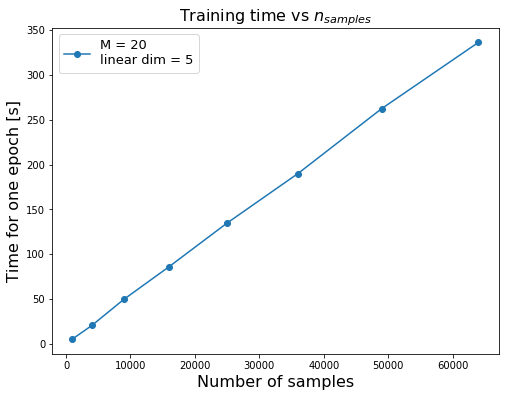

In [33]:
plt.figure(figsize=(8,6))
plt.plot(n_samples, times_n_samples, '-o', label='M = %d \nlinear dim = %d'%(M,linear_dim))
plt.xlabel("Number of samples", fontsize=16)
plt.ylabel("Time for one epoch [s]", fontsize=16)
plt.title(r"Training time vs $n_{samples}$", fontsize=16)
plt.legend(fontsize=13)
plt.show()

## Scaling in the number of pixels

In [34]:
linear_dims = np.arange(4,29,4)
print("Linear dimensions tested: \n", linear_dims)

# keep them fixed
n_samples = 1000
M = 20

Linear dimensions tested: 
 [ 4  8 12 16 20 24 28]


In [37]:
times_linear_dims = []
for linear_dim in linear_dims:
    print("Testing with %d x %d images..."%(linear_dim,linear_dim))
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    start = time.time()
    train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)
    dt = time.time() - start
    print("Time for 1 epoch: %.2f s \n"%dt)
    times_linear_dims.append(dt)

Testing with 4 x 4 images...


Epoch 0 - train accuracy : 0.9922 - val accuracy: 0.9812

Time for 1 epoch: 3.42 s 

Testing with 8 x 8 images...


Epoch 0 - train accuracy : 0.5578 - val accuracy: 0.5625

Time for 1 epoch: 13.65 s 

Testing with 12 x 12 images...


Epoch 0 - train accuracy : 0.9359 - val accuracy: 0.9250 

Time for 1 epoch: 31.80 s 

Testing with 16 x 16 images...


Epoch 0 - train accuracy : 0.4766 - val accuracy: 0.5188 

Time for 1 epoch: 58.87 s 

Testing with 20 x 20 images...


Epoch 0 - train accuracy : 0.5266 - val accuracy: 0.4813 

Time for 1 epoch: 95.17 s 

Testing with 24 x 24 images...


Epoch 0 - train accuracy : 0.4844 - val accuracy: 0.4875 

Time for 1 epoch: 127.21 s 

Testing with 28 x 28 images...


Epoch 0 - train accuracy : 0.5078 - val accuracy: 0.5375 

Time for 1 epoch: 172.25 s 



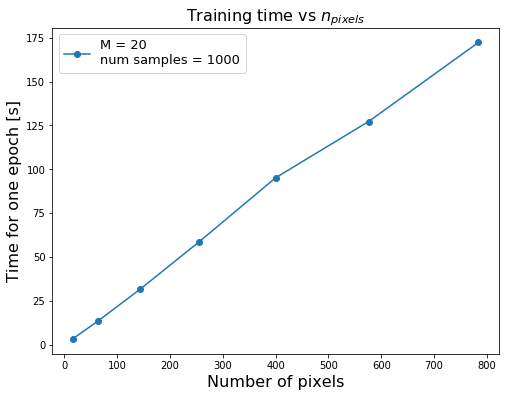

In [42]:
plt.figure(figsize=(8,6))
plt.plot(linear_dims**2, times_linear_dims, '-o', label='M = %d \nnum samples = %d'%(M,n_samples))
plt.xlabel("Number of pixels", fontsize=16)
plt.ylabel("Time for one epoch [s]", fontsize=16)
plt.title(r"Training time vs $n_{pixels}$", fontsize=16)
plt.legend(fontsize=13)
plt.show()

## Scaling in the bond dimension

In [43]:
Ms = [10*i for i in range(1,11)]
print("Bond dimensions tested: \n", Ms)

# keep them fixed
n_samples = 1000
linear_dim = 5

Bond dimensions tested: 
 [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [45]:
times_bond_dims = []
for M in Ms:
    print("Testing with bond dimension %d..."%M)
    (data, label) = gen.create_dataset(n_samples, sigma=0.7)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    start = time.time()
    train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)
    dt = time.time() - start
    print("Time for 1 epoch: %.2f s \n"%dt)
    times_bond_dims.append(dt)

Testing with bond dimension 10...


Epoch 0 - train accuracy : 0.9906 - val accuracy: 0.9750

Time for 1 epoch: 5.52 s 

Testing with bond dimension 20...


Epoch 0 - train accuracy : 0.9859 - val accuracy: 0.9750

Time for 1 epoch: 5.96 s 

Testing with bond dimension 30...


Epoch 0 - train accuracy : 0.9828 - val accuracy: 0.9688

Time for 1 epoch: 5.82 s 

Testing with bond dimension 40...


Epoch 0 - train accuracy : 0.9797 - val accuracy: 0.9938

Time for 1 epoch: 5.90 s 

Testing with bond dimension 50...


Epoch 0 - train accuracy : 0.9922 - val accuracy: 0.9750

Time for 1 epoch: 6.26 s 

Testing with bond dimension 60...


Epoch 0 - train accuracy : 0.9766 - val accuracy: 0.9812

Time for 1 epoch: 7.23 s 

Testing with bond dimension 70...


Epoch 0 - train accuracy : 0.9812 - val accuracy: 0.9750

Time for 1 epoch: 7.84 s 

Testing with bond dimension 80...


Epoch 0 - train accuracy : 0.9859 - val accuracy: 0.9875

Time for 1 epoch: 9.77 s 

Testing with bond dimension 90...


Epoch 0 - train accuracy : 0.9938 - val accuracy: 0.9938

Time for 1 epoch: 11.14 s 

Testing with bond dimension 100...


Epoch 0 - train accuracy : 0.9812 - val accuracy: 0.9812

Time for 1 epoch: 13.97 s 



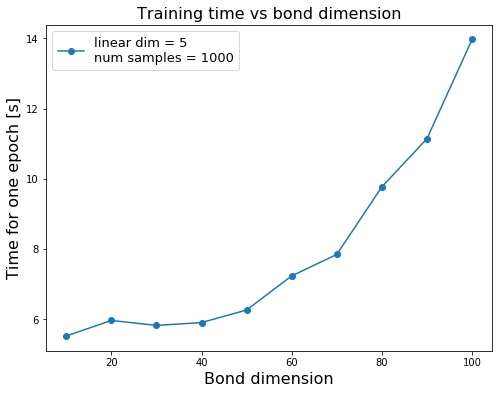

In [47]:
plt.figure(figsize=(8,6))
plt.plot(Ms, times_bond_dims, '-o', label='linear dim = %d \nnum samples = %d'%(linear_dim,n_samples))
plt.xlabel("Bond dimension", fontsize=16)
plt.ylabel("Time for one epoch [s]", fontsize=16)
plt.title("Training time vs bond dimension", fontsize=16)
plt.legend(fontsize=13)
plt.show()

## Weight initialization

**Objective:** study what is the dependence in the output magnitude of the various dimensions so that we can choose how to normalize the matrices A during initialization.

**Parameters:**
* Number of pixels N
* Bond dimension M
* Batch size B
* Embedding dimension D (fixed to 2)

Only the first 3 will be inquired.

**Methodology:** Use random input in [0,1] and random initialization in [0,1] for different dimensions and look at the absolute value of the output (take the output among the L with the highest absolute value).

In [7]:
from importlib import reload
reload(tn)

<module 'TensorNetwork' from '/home/nicola/Nicola_unipd/QuintoAnno/Quantum Information/TensorNetworkForML/TensorNetwork/TensorNetwork.py'>

### Dependence on the number of pixels N

In [80]:
linear_dims = np.arange(4,16)
print("Linear dimensions tested: \n", linear_dims)

# keep them fixed
n_samples = 1000
M = 20

Linear dimensions tested: 
 [ 4  5  6  7  8  9 10 11 12 13 14 15]


In [81]:
magnitude_linear_dims = []
for linear_dim in linear_dims:
    print("Testing with %d x %d images..."%(linear_dim,linear_dim))
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_linear_dims.append(f_max)

Testing with 4 x 4 images...
Testing with 5 x 5 images...
Testing with 6 x 6 images...
Testing with 7 x 7 images...
Testing with 8 x 8 images...
Testing with 9 x 9 images...
Testing with 10 x 10 images...
Testing with 11 x 11 images...
Testing with 12 x 12 images...
Testing with 13 x 13 images...
Testing with 14 x 14 images...
Testing with 15 x 15 images...


In [39]:
from sklearn.linear_model import LinearRegression

In [82]:
magnitude_linear_dims

[1.4551234878836874e+18,
 1.5954236860815993e+28,
 2.341730767267684e+40,
 2.1231127392977553e+55,
 7.706997101370749e+71,
 8.421848735099642e+90,
 1.0910929819827463e+112,
 1.4223183003637318e+136,
 4.445402669020557e+161,
 1.0891392090865922e+189,
 2.4658640147627255e+219,
 4.623475572905961e+251]

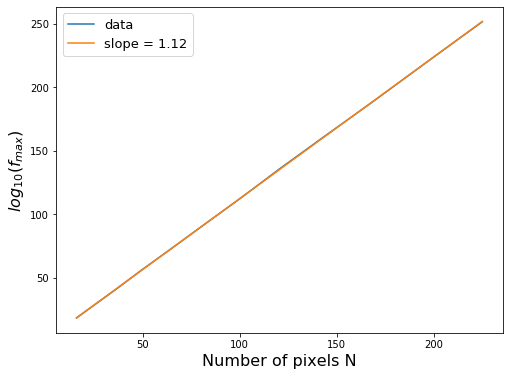

In [83]:
Ns = linear_dims**2
y = np.log10(magnitude_linear_dims)
X = Ns.reshape(-1,1)
reg = LinearRegression().fit(X, y)
plt.figure(figsize=(8,6))
plt.plot(Ns, y, label = 'data')
plt.plot(Ns, reg.predict(X), label = 'slope = %.2f'%reg.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel('Number of pixels N', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

As we can see the dependence on N is exponential, meaning that we can have an exponential suppression (or divergence) if the network is not accurately initialized.

### Isolating dependence C(N)

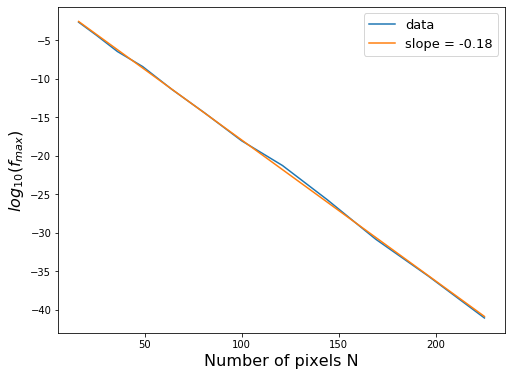

In [89]:
y_scaled = y - Ns*np.log10(M)
X = Ns.reshape(-1,1)
reg_C = LinearRegression().fit(X, y_scaled)
plt.figure(figsize=(8,6))
plt.plot(Ns, y_scaled, label = 'data')
plt.plot(Ns, reg_C.predict(X), label = 'slope = %.2f'%reg_C.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel('Number of pixels N', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

In [91]:
1/(10**(-0.18))

1.5135612484362082

### Bond dimension M

In [72]:
Ms = [5*i for i in range(1,21)]
print("Bond dimensions tested: \n", Ms)

# keep them fixed
n_samples = 1000
linear_dim = 5

Bond dimensions tested: 
 [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


In [73]:
magnitude_bond_dims = []
for M in Ms:
    print("Testing with bond dimension %d..."%M)
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim=linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_bond_dims.append(f_max)

Testing with bond dimension 5...
Testing with bond dimension 10...
Testing with bond dimension 15...
Testing with bond dimension 20...
Testing with bond dimension 25...
Testing with bond dimension 30...
Testing with bond dimension 35...
Testing with bond dimension 40...
Testing with bond dimension 45...
Testing with bond dimension 50...
Testing with bond dimension 55...
Testing with bond dimension 60...
Testing with bond dimension 65...
Testing with bond dimension 70...
Testing with bond dimension 75...
Testing with bond dimension 80...
Testing with bond dimension 85...
Testing with bond dimension 90...
Testing with bond dimension 95...
Testing with bond dimension 100...


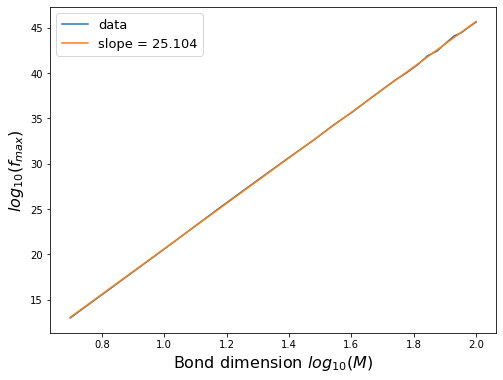

In [74]:
y = np.log10(magnitude_bond_dims)
X = np.log10(np.array(Ms)).reshape(-1,1)
reg_M = LinearRegression().fit(X, y)
plt.figure(figsize=(8,6))
plt.plot(X, y, label = 'data')
plt.plot(X, reg_M.predict(X), label = 'slope = %.3f'%reg_M.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel(r'Bond dimension $log_{10}(M)$', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

In [75]:
print(10**reg_M.intercept_)

3.1418028060393706e-05


The output magnitude has a power law dependence on the bond dimension. Notice how the slope is equal to N.
This makes sense since we already know that f is exponential in N. Now we also can approximate the scaling of the f as:
$$f \approx C(N)*M^N$$

### Batch dimension B

In [45]:
M = 20
n_samples = 1000
linear_dim = 5

train_batch_sizes = np.array([2**i for i in range(1,10)])

In [46]:
magnitude_batch_size = []
for B in train_batch_sizes:
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size': int(B), 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_batch_size.append(f_max)

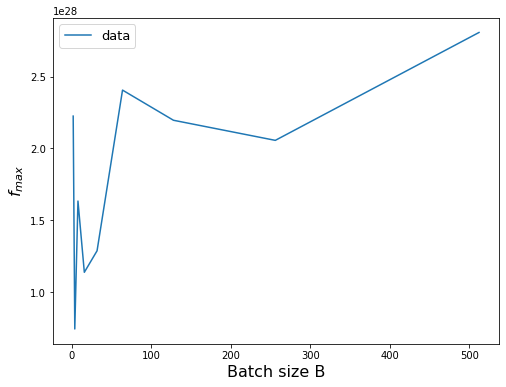

In [47]:
plt.figure(figsize=(8,6))
plt.plot(train_batch_sizes, magnitude_batch_size, label = 'data')
plt.ylabel(r'$f_{max}$', fontsize = 16)
plt.xlabel('Batch size B', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

No clear dependence emerges on the batch size.

### Conclusion on initialization

The simplest and most reliable initialization is the one that takes into account the number of pixels given as input and disregards all the rest. However remains the problem of choosing the factor with which the weights should be divided. To find an exact factor a priori is not immediate and is also a risky procedure, hence it's better to devise an empirical method to do so.



In [180]:
linear_dim = 5
n_samples = 1000
M = 10

In [181]:
reload(tn)

<module 'TensorNetwork' from '/home/nicola/Nicola_unipd/QuintoAnno/Quantum Information/TensorNetworkForML/TensorNetwork/TensorNetwork.py'>

In [182]:
Cs = np.arange(1,21)
(data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
batch = next(iter(train_loader))
X = np.array([batch[i][0] for i in range(len(batch))])

magnitude_C = []
for C in Cs:
    
    net = tn.Network(N=linear_dim**2, M=M, L=2, normalize=False)
    
    for i in range(net.N):
        net.As[i].elem *= C
    
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    print('f_max: ', f_max)
    magnitude_C.append(f_max)

f_max:  7.507434773510061e+20
f_max:  1.5437171228476673e+28
f_max:  5.551181947055209e+32
f_max:  7.236974553759592e+35
f_max:  1.6241222002361267e+38
f_max:  1.7678852010787924e+40
f_max:  9.794258744717153e+41
f_max:  1.3659012632968806e+43
f_max:  3.2136563727874105e+44
f_max:  7.688763989726357e+45
f_max:  6.898674744968914e+46
f_max:  6.906263911968347e+47
f_max:  3.6877261059016915e+48
f_max:  2.783268384091837e+49
f_max:  1.7585207186567073e+50
f_max:  7.111076014174207e+50
f_max:  2.6385043554830724e+51
f_max:  1.9025690587197457e+52
f_max:  6.325542984536105e+52
f_max:  2.113621761049667e+53


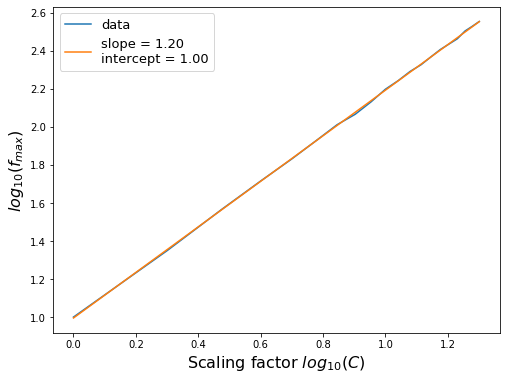

In [183]:
plt.figure(figsize=(8,6))
X = np.log10(Cs).reshape(-1,1)
y = np.log10(np.array(magnitude_C))
y = y/y[0]
reg_scale = LinearRegression().fit(X, y)
plt.plot(X, y, label='data')
plt.plot(X, reg_scale.predict(X), label = 'slope = %.2f\nintercept = %.2f'%(reg_scale.coef_,reg_scale.intercept_))
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel(r'Scaling factor $log_{10}(C)$', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

In [185]:
Ms = np.array([5*i for i in range(1,21)])
Cs = np.arange(1,21)
(data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
batch = next(iter(train_loader))
X = np.array([batch[i][0] for i in range(len(batch))])

magnitude_C_M = []
for M in Ms:
    magnitude_C = []
    for C in Cs:

        net = tn.Network(N=linear_dim**2, M=M, L=2, normalize=False)

        for i in range(net.N):
            net.As[i].elem *= C

        f = net.forward(X)
        f_max = np.abs(f.elem).max()
        magnitude_C.append(f_max)
        
    magnitude_C = np.array(magnitude_C)
    magnitude_C_M.append(magnitude_C)
    
magnitude_C_M = np.array(magnitude_C_M)

In [186]:
magnitude_C_M.shape

(20, 20)

In [187]:
alphas = []
for i,M in enumerate(Ms):
    X = np.log10(Cs).reshape(-1,1)
    y = np.log10(np.array(magnitude_C_M[i,:]))
    y = y/y[0]
    reg = LinearRegression().fit(X, y)
    alphas.append(reg.coef_)
alphas = np.array(alphas)

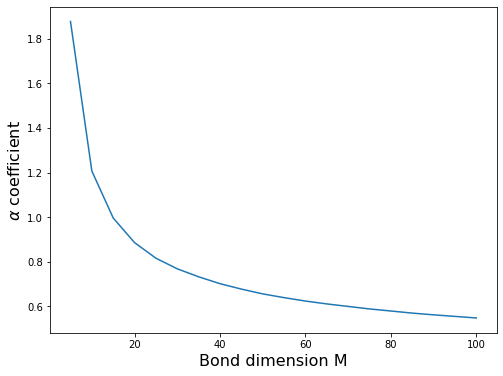

In [199]:
plt.figure(figsize=(8,6))
plt.plot(Ms, alphas)
plt.xlabel('Bond dimension M', fontsize=16)
plt.ylabel(r'$\alpha$ coefficient', fontsize=16)
plt.show()

In [233]:
reload(tn)

<module 'TensorNetwork' from '/home/nicola/Nicola_unipd/QuintoAnno/Quantum Information/TensorNetworkForML/TensorNetwork/TensorNetwork.py'>

In [227]:
linear_dims = np.arange(4,29,4)
print("Linear dimensions tested: \n", linear_dims)

# keep them fixed
n_samples = 1000
M = 20

Linear dimensions tested: 
 [ 4  8 12 16 20 24 28]


In [228]:
magnitude_linear_dims = []
for linear_dim in linear_dims:
    print("Testing with %d x %d images..."%(linear_dim,linear_dim))
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2, normalize=True)
    
    batch = next(iter(train_loader))
    X = np.array([batch[i][0] for i in range(len(batch))])
    f = net.forward(X)
    f_max = np.abs(f.elem).max()
    magnitude_linear_dims.append(f_max)

Testing with 4 x 4 images...
Normalizing weights...
K 0.8052451659746271
Scaling factor: 8.28
f_max for random input of 16 samples :  176.00470488576988
f_max for random input of 16 samples (after):  1.000000000000001
Testing with 8 x 8 images...
Normalizing weights...
K 0.9269895625416927
Scaling factor: 7.19
f_max for random input of 16 samples :  1955561060.7934592
f_max for random input of 16 samples (after):  0.9999999999999974
Testing with 12 x 12 images...
Normalizing weights...
K 0.9614371194830902
Scaling factor: 6.93
f_max for random input of 16 samples :  3.574725214663069e+20
f_max for random input of 16 samples (after):  0.9999999999999913
Testing with 16 x 16 images...
Normalizing weights...
K 0.9759260581154892
Scaling factor: 6.83
f_max for random input of 16 samples :  4.1529657123946844e+39
f_max for random input of 16 samples (after):  1.0000000000000138
Testing with 20 x 20 images...
Normalizing weights...
K 0.9834273336732188
Scaling factor: 6.78
f_max for random i

In [225]:
u = np.random.random(10000)
x = np.cos(np.pi/2*u)
x.mean()

0.6400077874061286

In [53]:
magnitude_linear_dims

[1.0620975310181947e+18,
 8.427103912844499e+71,
 4.843395114717482e+161,
 2.9342476310677695e+286,
 inf,
 inf,
 inf]

In [ ]:
Ns = linear_dims**2
y = np.log10(magnitude_linear_dims)
X = Ns.reshape(-1,1)
reg = LinearRegression().fit(X, y)
plt.figure(figsize=(8,6))
plt.plot(Ns, y, label = 'data')
plt.plot(Ns, reg.predict(X), label = 'slope = %.2f'%reg.coef_)
plt.ylabel(r'$log_{10}(f_{max})$', fontsize = 16)
plt.xlabel('Number of pixels N', fontsize = 16)
plt.legend(fontsize=13)
plt.show()

### Gradient clipping
**Idea**: 

# MNIST dataset

In [108]:
MNIST_data = gen.get_MNIST_dataset(data_root_dir = './datasets', download=False)
train_data, train_labels, test_data, test_labels = MNIST_data
data = np.concatenate((train_data,test_data))
labels = np.concatenate((train_labels,test_labels))
batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, labels, 6/7, 0.2, **batch_size)

In [172]:
reload(tn)

<module 'TensorNetwork' from '/home/nicola/Nicola_unipd/QuintoAnno/Quantum Information/TensorNetworkForML/TensorNetwork/TensorNetwork.py'>

In [173]:
net = tn.Network(N=784, M=5, L=10, normalize=True)#, sigma=0.23)

Normalizing weights...
K 0.9906592602734394
Scaling factor: 1.68
f_max for random input of 16 samples :  1.6482741561078607e+102
f_max for random input of 16 samples (after):  1.0000000000000133


In [174]:
train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1000)


B.elem.sum():  222.97100663894082
deltaB.elem.sum():  -5.058290809649901e+63
B.elem.sum() (after update):  -5.058290809649902e+63

SVD debug:  True
T.elem.shape:  (10, 100)
T.elem.sum():  -5.058290809649902e+63
m:  5
T_new.shape:  (10, 100)
T_new.sum():  -5.058290809649903e+63
U.shape (10, 5)
U.sum -2.0050903688444435
S.shape (5, 5)
S.sum -3.3543788509341214e+62
Vh.shape (5, 100)
Vh.sum -14.262544287470757
SVh.shape (5, 100)
SVh.sum 2.276066777077014e+63

B.elem.sum():  5.772006759155874e+63
deltaB.elem.sum():  -1.537248238348008e+125
B.elem.sum() (after update):  -1.537248238348008e+125

SVD debug:  True
T.elem.shape:  (10, 100)
T.elem.sum():  -1.5372482383480083e+125
m:  5
T_new.shape:  (10, 100)
T_new.sum():  -1.5372482383480083e+125
U.shape (10, 5)
U.sum -3.14493318506812
S.shape (5, 5)
S.sum -2.3852246040965747e+124
Vh.shape (5, 100)
Vh.sum -6.55626667169796
SVh.shape (5, 100)
SVh.sum 1.537248238348008e+125

B.elem.sum():  3.244276426967673e+125
deltaB.elem.sum():  -9.41543401865

/home/nicola/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/nicola/Nicola_unipd/QuintoAnno/Quantum Information/TensorNetworkForML/TensorNetwork/TensorNetwork.py:515: RuntimeWarning: invalid value encountered in greater
  index = np.argmax(cumulative_variance_explained>threshold)


LinAlgError: SVD did not converge